In [1]:
from typing import List, Union

from numpy import sqrt, isinf
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True,
               display_expand_data=False)

import plotly.express as px
import plotly.io as pio
# pio.renderers.default='png'

import yfinance as yf

from stats import get_factor_data
from chart import draw_volatility, draw_correlation


In [2]:
halflifes = [21, 63, 126, 252, 512]
data = get_factor_data(halflifes)
factor_master = pd.DataFrame(data['asset'].attrs).T
factor_list = factor_master.index.to_list()

[*********************100%%**********************]  30 of 30 completed


In [3]:
draw_volatility(data.vol, asset='QQQ', vol_type=[21, 63]).show()
draw_correlation(data.corr, asset='QQQ', asset_1='IWM', corr_type=[21, 63]).show()

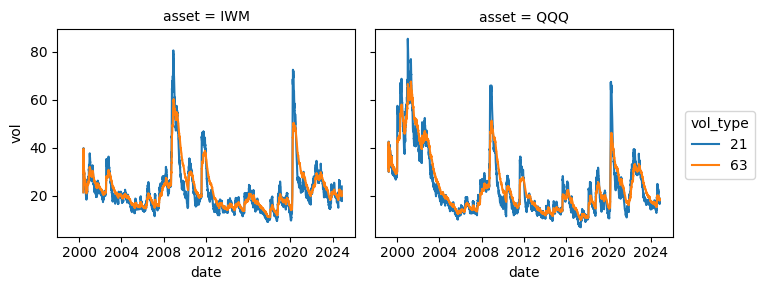

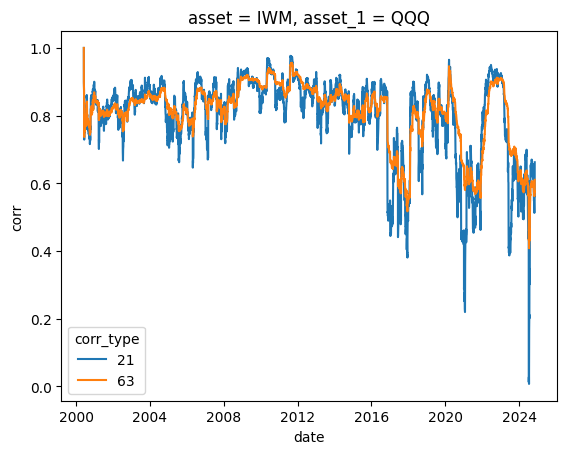

asset_1,SPY,QQQ,IWM
asset,,,
SPY,1.000000,0.946073,0.729082
QQQ,0.946073,1.000000,0.610417
IWM,0.729082,0.610417,1.000000


In [4]:
import matplotlib.pyplot as plt

data.vol.sel(asset=['IWM', 'QQQ'], vol_type=[21, 63]).plot(hue='vol_type', col='asset')
plt.show()

data.corr.sel(asset='IWM', asset_1='QQQ', corr_type=[21, 63]).plot(hue='corr_type')
plt.show()

corr_list = ['SPY', 'QQQ', 'IWM']
data.corr.sel(date=data.date.max(), asset=corr_list, asset_1=corr_list, corr_type=63).to_pandas()

In [5]:
data

<xarray.Dataset> Size: 594MB
Dimensions:     (date: 15175, ohlcv_type: 6, asset: 30, vol_type: 5,
                 asset_1: 30, corr_type: 5)
Coordinates:
  * date        (date) datetime64[ns] 121kB 1965-01-05 1965-01-06 ... 2024-11-06
  * ohlcv_type  (ohlcv_type) object 48B 'adj close' 'close' ... 'open' 'volume'
  * asset       (asset) object 240B 'SPY' 'IWM' 'QQQ' ... 'UUP' 'FXE' 'FXY'
  * vol_type    (vol_type) int64 40B 21 63 126 252 512
  * asset_1     (asset_1) object 240B 'SPY' 'IWM' 'QQQ' ... 'UUP' 'FXE' 'FXY'
  * corr_type   (corr_type) int64 40B 21 63 126 252 512
Data variables:
    ohlcv       (date, ohlcv_type, asset) float64 22MB nan nan ... 2.208e+05
    cret        (date, asset) float64 4MB nan nan nan nan ... 29.55 99.07 59.85
    ret         (date, asset) float64 4MB nan nan nan ... -0.01755 -0.0189
    vol         (vol_type, date, asset) float64 18MB nan nan nan ... 7.43 9.973
    corr        (corr_type, date, asset, asset_1) float64 546MB nan nan ... 1.0

In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Charting scratch

In [ ]:
def format_plotly_title(title: str, subtitles: List[str]) -> dict:
    """
    Format a title and a list of subtitles for a Plotly chart.

    Parameters
    ----------
    title : str
        The main title of the chart.
    subtitles : List[str]
        A list of subtitles for the chart.

    Returns
    -------
    dict
        A dictionary containing the formatted title and subtitles for Plotly.
    """
    # subtitle_text = "<br>".join([f"<sup>{subtitle}</sup>" for subtitle in subtitles])
    subtitle_text = f'<span style="font size: 12px;">{"<br>".join(subtitles)}</span>'
    return {
        'text': f'{title}<br><span style="font size: 12px;">{"<br>".join(subtitles)}</span>',
        # 'x': 0.5,
        # 'xanchor': 'center',
        # 'yanchor': 'top'
    }

# Example usage:
formatted_title = format_plotly_title("Main Title", ["Subtitle 1", "Subtitle 2"])
fig.update_layout(title=formatted_title)
fig.show()
formatted_title

In [ ]:
from typing import Union

def format_plotly_title(title: str, subtitles: Union[str, List[str]]) -> dict:
    """
    Format a title and a list of subtitles for a Plotly chart.

    Parameters
    ----------
    title : str
        The main title of the chart.
    subtitles : Union[str, List[str]]
        A single subtitle or a list of subtitles for the chart.

    Returns
    -------
    dict
        A dictionary containing the formatted title and subtitles for Plotly.
    """
    if isinstance(subtitles, str):
        subtitles = [subtitles]
    subtitle_text = f'<span style="font size: 12px;">{"<br>".join(subtitles)}</span>'
    return {
        'text': f'{title}<br><span style="font size: 12px;">{"<br>".join(subtitles)}</span>',
    }

# Example usage:
formatted_title = format_plotly_title("Main Title", "Single Subtitle")
fig.update_layout(title=formatted_title)
fig.show()
formatted_title


In [ ]:
def plotly_line_chart(da: xr.DataArray, x: str, y: str, color: str = None, title: str = "Line Chart") -> None:
    """
    Produce a Plotly Express line chart given an xarray DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The input xarray DataArray.
    x : str
        The name of the dimension to use for the x-axis.
    y : str
        The name of the dimension to use for the y-axis.
    color : str, optional
        The name of the dimension to use for color grouping, by default None.
    title : str, optional
        The title of the chart, by default "Line Chart".

    Returns
    -------
    None
    """
    df = da.to_series().reset_index()
    fig = px.line(df, x=x, y=y, color=color, title=title, template='plotly_white')
    fig.show()

# Example usage:
# plotly_line_chart(ds.vol, x='date', y='vol', color='vol_type', title='Volatility Over Time')

In [ ]:
da = data.ret.sel(asset='QQQ') / data.ret.sel(asset='IWM')
# data.ret.assign_coordinate()